In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
import joblib
from sklearn.svm import SVC
from collections import Counter
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### 단어사전 5000개


In [64]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)
print("x_train :", len(x_train))
print("y_train :", len(y_train))
print("x_test :", len(x_test))
print("y_test :", len(y_test))

num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

word_index = reuters.get_word_index()
min_index = min(word_index.values())
print("word_index의 가장 작은 인덱스는?", min_index)

print('가장 작은 값의 단어가?')
for word, index in word_index.items():
    if index == min_index:
        print(f"min ,({min_index})의 단어 : {word}")

# word_index를 기반으로 index_to_word 생성 인덱스가 1부터 시작하므로 2만 추가해도 3개 전부 추가가능
index_to_word = {index + 2: word for word, index in word_index.items()}

# 특수 토큰 추가
index_to_word.update({0: "<pad>", 1: "<sos>", 2: "<unk>"})

# 확인
print("특수 토큰 확인")
for key in range(5):
    print(f"index_to_word[{key}]: {index_to_word.get(key, '키 없음')}")

print(' '.join([index_to_word[index] for index in x_train[0]]))

print("x_train의 범위:")
print("최소값:", min(min(doc) for doc in x_train))
print("최대값:", max(max(doc) for doc in x_train))

print("index_to_word의 범위1:")
print("최소값:", min(index_to_word.keys()))
print("최대값:", max(index_to_word.keys()))

x_train_text = [" ".join(index_to_word.get(idx, "<unk>") for idx in doc) for doc in x_train]
x_test_text = [" ".join(index_to_word.get(idx, "<unk>") for idx in doc) for doc in x_test]

# CountVectorizer를 사용해 단어 빈도 계산
vectorizer = CountVectorizer()
x_train_counts = vectorizer.fit_transform(x_train_text)
x_test_counts = vectorizer.transform(x_test_text)

# TF-IDF
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

print("x_train_tfidf shape:", x_train_tfidf.shape)
print("x_test_tfidf shape:", x_test_tfidf.shape)

x_train : 8982
y_train : 8982
x_test : 2246
y_test : 2246
클래스의 수 : 46
word_index의 가장 작은 인덱스는? 1
가장 작은 값의 단어가?
min ,(1)의 단어 : the
특수 토큰 확인
index_to_word[0]: <pad>
index_to_word[1]: <sos>
index_to_word[2]: <unk>
index_to_word[3]: the
index_to_word[4]: of
<sos> <unk> <unk> and 5 mln 1988 to cts due his to juice against reuter being 14 may one said per to pct group in pct their it may one been is here by said company of which and 66 has only six in added in up 3 it is 31 3 it said company a herald form francs in commission in ended 3 it is total not 3 it reuter and export representatives may one shr be only with will expected in january it 000 for
x_train의 범위:
최소값: 1
최대값: 4999
index_to_word의 범위1:
최소값: 0
최대값: 30981
x_train_tfidf shape: (8982, 4867)
x_test_tfidf shape: (2246, 4867)


In [53]:
# 학습
model = LogisticRegression(
    C=10000,             # 규제 강도 설정
    penalty='l2',        # L2 규제
    max_iter=3000,       # 최대 반복 수
    solver='saga',
    verbose=1
)
model.fit(x_train_tfidf, y_train)

y_pred = model.predict(x_test_tfidf)
y_prob = model.predict_proba(x_test_tfidf) # 각 label 별 prob

# Acc & F1-Score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

max_iter reached after 562 seconds
Accuracy: 0.8023152270703473
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.72      0.77      0.75       105
           2       0.75      0.75      0.75        20
           3       0.91      0.92      0.92       813
           4       0.80      0.88      0.84       474
           5       0.33      0.20      0.25         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.60      0.76      0.67        38
           9       0.80      0.80      0.80        25
          10       0.93      0.83      0.88        30
          11       0.64      0.73      0.69        83
          12       0.50      0.38      0.43        13
          13       0.65      0.65      0.65        37
          14       0.50      0.50      0.50         2
          15       0.75      0.33      0.46     

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [54]:
# 과적합 방지
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,           # 깊이 제한을 둬서 규제
    min_samples_split=5,    # 최소 분할 제한
    min_samples_leaf=2,     # 리프 제한
    max_features="sqrt",
    random_state=42,
    class_weight="balanced" # 클래스 불균형 처리
)

# 모델 학습
rf_model.fit(x_train_tfidf, y_train)

# 예측
y_pred = rf_model.predict(x_test_tfidf)

# Acc
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(y_test, y_pred, average="weighted")  # 가중 평균 F1-Score
print("Weighted F1-Score:", f1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.6273374888691006
Weighted F1-Score: 0.6467420617835363
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.75      0.51        12
           1       0.83      0.38      0.52       105
           2       0.63      0.85      0.72        20
           3       0.94      0.82      0.88       813
           4       0.74      0.43      0.55       474
           5       0.12      0.60      0.21         5
           6       0.65      0.93      0.76        14
           7       0.20      1.00      0.33         3
           8       0.47      0.58      0.52        38
           9       0.36      0.92      0.52        25
          10       0.83      0.97      0.89        30
          11       0.69      0.33      0.44        83
          12       0.30      0.77      0.43        13
          13       0.36      0.49      0.41        37
          14       0.17      1.00      0.29         2
          15       0.31      0.56      0.40  

In [66]:
# SVM 모델 생성 (규제 완화)
svm_model = SVC(
    kernel='rbf',
    C=10,             # 규제 완화 (값을 증가)
    gamma=0.1,        # 중간 범위의 영향을 고려
    probability=True  # 확률 출력
)
svm_model.fit(x_train_tfidf, y_train)

# 예측
y_pred = svm_model.predict(x_test_tfidf)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# F1-Score 평가
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8272484416740873
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        12
           1       0.69      0.81      0.74       105
           2       0.79      0.75      0.77        20
           3       0.92      0.94      0.93       813
           4       0.80      0.91      0.85       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.71      0.71      0.71        38
           9       0.81      0.88      0.85        25
          10       0.93      0.83      0.88        30
          11       0.76      0.82      0.79        83
          12       0.88      0.54      0.67        13
          13       0.66      0.68      0.67        37
          14       0.50      1.00      0.67         2
          15       0.75      0.33      0.46         9
          16       0.74      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 단어사전 10000개

In [67]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)
print("x_train :", len(x_train))
print("y_train :", len(y_train))
print("x_test :", len(x_test))
print("y_test :", len(y_test))

num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

word_index = reuters.get_word_index()
min_index = min(word_index.values())
print("word_index의 가장 작은 인덱스는?", min_index)

print('가장 작은 값의 단어가?')
for word, index in word_index.items():
    if index == min_index:
        print(f"min ,({min_index})의 단어 : {word}")

# word_index를 기반으로 index_to_word 생성 인덱스가 1부터 시작하므로 2만 추가해도 3개 전부 추가가능
index_to_word = {index + 2: word for word, index in word_index.items()}

# 특수 토큰 추가
index_to_word.update({0: "<pad>", 1: "<sos>", 2: "<unk>"})

# 확인
print("특수 토큰 확인")
for key in range(5):
    print(f"index_to_word[{key}]: {index_to_word.get(key, '키 없음')}")

print(' '.join([index_to_word[index] for index in x_train[0]]))

print("x_train의 범위:")
print("최소값:", min(min(doc) for doc in x_train))
print("최대값:", max(max(doc) for doc in x_train))

print("index_to_word의 범위1:")
print("최소값:", min(index_to_word.keys()))
print("최대값:", max(index_to_word.keys()))

# x_train, x_test를 텍스트로 변환
x_train_text = [" ".join(index_to_word.get(idx, "<unk>") for idx in doc) for doc in x_train]
x_test_text = [" ".join(index_to_word.get(idx, "<unk>") for idx in doc) for doc in x_test]

# CountVectorizer를 사용해 단어 빈도 계산
vectorizer = CountVectorizer()
x_train_counts = vectorizer.fit_transform(x_train_text)
x_test_counts = vectorizer.transform(x_test_text)

# TF-IDF로 변환
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

# 결과 확인
print("x_train_tfidf shape:", x_train_tfidf.shape)
print("x_test_tfidf shape:", x_test_tfidf.shape)

x_train : 8982
y_train : 8982
x_test : 2246
y_test : 2246
클래스의 수 : 46
word_index의 가장 작은 인덱스는? 1
가장 작은 값의 단어가?
min ,(1)의 단어 : the
특수 토큰 확인
index_to_word[0]: <pad>
index_to_word[1]: <sos>
index_to_word[2]: <unk>
index_to_word[3]: the
index_to_word[4]: of
<sos> <unk> <unk> and 5 mln 1988 to cts due his to juice against reuter being 14 may one said per to pct group in pct their it may one been is here by said company of which and 66 has only six in added in up 3 it is 31 3 it said company a herald form francs in commission in ended 3 it is total not 3 it reuter and export representatives may one shr be only with will expected in january it 000 for
x_train의 범위:
최소값: 1
최대값: 9999
index_to_word의 범위1:
최소값: 0
최대값: 30981
x_train_tfidf shape: (8982, 9670)
x_test_tfidf shape: (2246, 9670)


In [56]:
# 학습
model = LogisticRegression(
    C=10000,             # 규제 강도 설정
    penalty='l2',        # L2 규제
    max_iter=3000,       # 최대 반복 수
    solver='saga',
    verbose=1
)
model.fit(x_train_tfidf, y_train)

y_pred = model.predict(x_test_tfidf)
y_prob = model.predict_proba(x_test_tfidf) # 각 label 별 prob

# Acc & F1-Score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

max_iter reached after 554 seconds
Accuracy: 0.804986642920748
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.74      0.74      0.74       105
           2       0.75      0.75      0.75        20
           3       0.91      0.93      0.92       813
           4       0.82      0.86      0.84       474
           5       1.00      0.20      0.33         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.68      0.71      0.69        38
           9       0.81      0.88      0.85        25
          10       0.93      0.87      0.90        30
          11       0.67      0.73      0.70        83
          12       0.55      0.46      0.50        13
          13       0.56      0.65      0.60        37
          14       0.20      0.50      0.29         2
          15       0.80      0.44      0.57      

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [57]:
# 랜덤 포레스트 모델 생성
rf_model = RandomForestClassifier(
    n_estimators=100,  # 트리 개수
    max_depth=None,    # 트리의 최대 깊이
    random_state=42,   # 재현성을 위한 시드 설정
    class_weight="balanced"  # 클래스 불균형 처리
)
rf_model.fit(x_train_tfidf, y_train)

# 예측
y_pred = rf_model.predict(x_test_tfidf)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# F1-Score 평가
f1 = f1_score(y_test, y_pred, average="weighted")  # 가중 평균 F1-Score
print("Weighted F1-Score:", f1)

# 상세 보고서 출력
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.7773820124666073
Weighted F1-Score: 0.769560939253692
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.60      0.75      0.67       105
           2       0.79      0.75      0.77        20
           3       0.94      0.87      0.90       813
           4       0.67      0.89      0.77       474
           5       0.00      0.00      0.00         5
           6       0.87      0.93      0.90        14
           7       1.00      0.33      0.50         3
           8       0.81      0.79      0.80        38
           9       0.80      0.80      0.80        25
          10       0.90      0.87      0.88        30
          11       0.71      0.69      0.70        83
          12       0.56      0.38      0.45        13
          13       0.63      0.51      0.57        37
          14       0.20      0.50      0.29         2
          15       0.00      0.00      0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [68]:
# SVM 모델 생성 (규제 완화)
svm_model = SVC(
    kernel='rbf',
    C=10,             # 규제 완화 (값을 증가)
    gamma=0.1,        # 중간 범위의 영향을 고려
    probability=True  # 확률 출력
)
svm_model.fit(x_train_tfidf, y_train)

# 예측
y_pred = svm_model.predict(x_test_tfidf)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# F1-Score 평가
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8236865538735529
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.71      0.81      0.76       105
           2       0.79      0.75      0.77        20
           3       0.93      0.94      0.93       813
           4       0.80      0.90      0.85       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.33      0.50         3
           8       0.71      0.71      0.71        38
           9       0.82      0.92      0.87        25
          10       0.93      0.87      0.90        30
          11       0.73      0.80      0.76        83
          12       0.88      0.54      0.67        13
          13       0.65      0.59      0.62        37
          14       0.50      1.00      0.67         2
          15       0.75      0.33      0.46         9
          16       0.73      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 단어사전 NONE

In [69]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)
print("x_train :", len(x_train))
print("y_train :", len(y_train))
print("x_test :", len(x_test))
print("y_test :", len(y_test))

num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

# word_index = reuters.get_word_index(path="reuters_word_index.json")
word_index = reuters.get_word_index()
min_index = min(word_index.values())
print("word_index의 가장 작은 인덱스는?", min_index)

print('가장 작은 값의 단어가?')
for word, index in word_index.items():
    if index == min_index:
        print(f"min ,({min_index})의 단어 : {word}")

# word_index를 기반으로 index_to_word 생성 인덱스가 1부터 시작하므로 2만 추가해도 3개 전부 추가가능
index_to_word = {index + 2: word for word, index in word_index.items()}

# 특수 토큰 추가
index_to_word.update({0: "<pad>", 1: "<sos>", 2: "<unk>"})

# 확인
print("특수 토큰 확인")
for key in range(5):
    print(f"index_to_word[{key}]: {index_to_word.get(key, '키 없음')}")

print(' '.join([index_to_word[index] for index in x_train[0]]))

print(index_to_word[3])
print(index_to_word[15])

print(' '.join([index_to_word[index] for index in x_train[0]]))

print("x_train의 범위:")
print("최소값:", min(min(doc) for doc in x_train))
print("최대값:", max(max(doc) for doc in x_train))

print("index_to_word의 범위1:")
print("최소값:", min(index_to_word.keys()))
print("최대값:", max(index_to_word.keys()))

# x_train, x_test를 텍스트로 변환
x_train_text = [" ".join(index_to_word.get(idx, "<unk>") for idx in doc) for doc in x_train]
x_test_text = [" ".join(index_to_word.get(idx, "<unk>") for idx in doc) for doc in x_test]

# CountVectorizer를 사용해 단어 빈도 계산
vectorizer = CountVectorizer()
x_train_counts = vectorizer.fit_transform(x_train_text)
x_test_counts = vectorizer.transform(x_test_text)

# TF-IDF로 변환
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

# 결과 확인
print("x_train_tfidf shape:", x_train_tfidf.shape)
print("x_test_tfidf shape:", x_test_tfidf.shape)

x_train : 8982
y_train : 8982
x_test : 2246
y_test : 2246
클래스의 수 : 46
word_index의 가장 작은 인덱스는? 1
가장 작은 값의 단어가?
min ,(1)의 단어 : the
특수 토큰 확인
index_to_word[0]: <pad>
index_to_word[1]: <sos>
index_to_word[2]: <unk>
index_to_word[3]: the
index_to_word[4]: of
<sos> koaq atom and 5 mln 1988 to cts due his to juice against reuter being 14 may one said per to pct group in pct their it may one been is here by said company of which and 66 has only six in added in up 3 it is 31 3 it said company a herald form francs in commission in ended 3 it is total not 3 it reuter and export representatives may one shr be only with will expected in january it 000 for
the
it
<sos> koaq atom and 5 mln 1988 to cts due his to juice against reuter being 14 may one said per to pct group in pct their it may one been is here by said company of which and 66 has only six in added in up 3 it is 31 3 it said company a herald form francs in commission in ended 3 it is total not 3 it reuter and export representatives may one

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


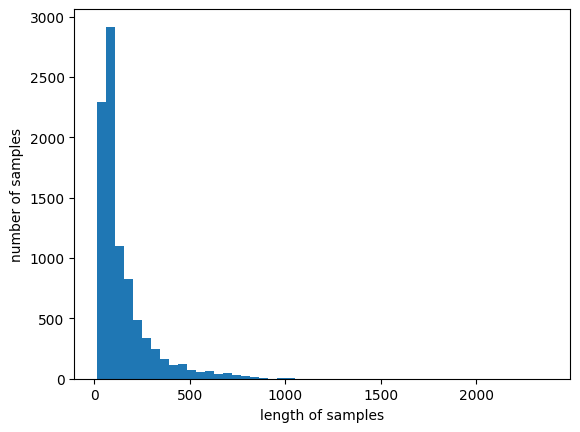

In [59]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

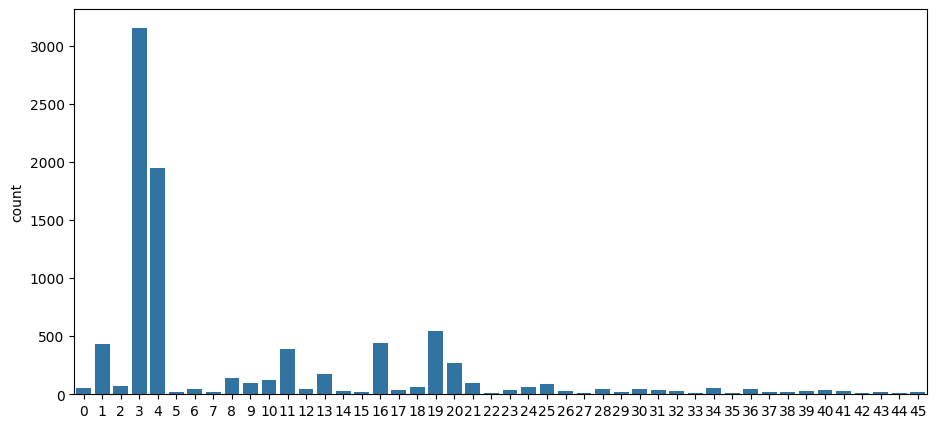

In [60]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [61]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [62]:
# 학습
model = LogisticRegression(
    C=10000,             # 규제 강도 설정
    penalty='l2',        # L2 규제
    max_iter=3000,       # 최대 반복 수
    solver='saga',
    verbose=1
)
model.fit(x_train_tfidf, y_train)

y_pred = model.predict(x_test_tfidf)
y_prob = model.predict_proba(x_test_tfidf) # 각 label 별 prob

# Acc & F1-Score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

max_iter reached after 652 seconds
Accuracy: 0.8170080142475512
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.75      0.80      0.77       105
           2       0.75      0.75      0.75        20
           3       0.92      0.93      0.93       813
           4       0.81      0.88      0.85       474
           5       1.00      0.20      0.33         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.64      0.74      0.68        38
           9       0.81      0.84      0.82        25
          10       0.93      0.87      0.90        30
          11       0.69      0.73      0.71        83
          12       0.60      0.46      0.52        13
          13       0.68      0.68      0.68        37
          14       0.50      0.50      0.50         2
          15       0.80      0.44      0.57     

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [63]:
# 과적합 방지
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,           # 깊이 제한을 둬서 규제
    min_samples_split=5,    # 최소 분할 제한
    min_samples_leaf=2,     # 리프 제한
    max_features="sqrt",
    random_state=42,
    class_weight="balanced" # 클래스 불균형 처리
)

# 모델 학습
rf_model.fit(x_train_tfidf, y_train)

# 예측
y_pred = rf_model.predict(x_test_tfidf)

# Acc
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# F1 Score
f1 = f1_score(y_test, y_pred, average="weighted")  # 가중 평균 F1-Score
print("Weighted F1-Score:", f1)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.5837043633125557
Weighted F1-Score: 0.6086774499897086
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.67      0.40        12
           1       0.83      0.33      0.48       105
           2       0.58      0.70      0.64        20
           3       0.93      0.80      0.86       813
           4       0.75      0.36      0.48       474
           5       0.04      0.40      0.08         5
           6       0.65      0.93      0.76        14
           7       0.15      1.00      0.26         3
           8       0.46      0.45      0.45        38
           9       0.56      0.96      0.71        25
          10       0.62      0.80      0.70        30
          11       0.70      0.37      0.49        83
          12       0.17      0.77      0.28        13
          13       0.48      0.41      0.44        37
          14       0.13      1.00      0.24         2
          15       0.15      0.67      0.24  

In [70]:
# SVM 모델 생성 (규제 완화)
svm_model = SVC(
    kernel='rbf',
    C=10,             # 규제 완화 (값을 증가)
    gamma=0.1,        # 중간 범위의 영향을 고려
    probability=True  # 확률 출력
)
svm_model.fit(x_train_tfidf, y_train)

# 예측
y_pred = svm_model.predict(x_test_tfidf)

# 정확도 평가
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# F1-Score 평가
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8254674977738201
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.70      0.80      0.75       105
           2       0.79      0.75      0.77        20
           3       0.93      0.94      0.93       813
           4       0.80      0.90      0.85       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.33      0.50         3
           8       0.71      0.71      0.71        38
           9       0.82      0.92      0.87        25
          10       0.93      0.87      0.90        30
          11       0.72      0.80      0.75        83
          12       0.88      0.54      0.67        13
          13       0.65      0.65      0.65        37
          14       0.67      1.00      0.80         2
          15       0.75      0.33      0.46         9
          16       0.75      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
# 클래스별 샘플 개수 확인
class_counts = Counter(y_train)
print("클래스별 샘플 개수:", class_counts)

# 클래스별 가중치 계산 (반비례 가중치)
total_samples = len(y_train)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
print("클래스별 가중치:", class_weights)

# y_train의 가중치를 생성
sample_weights = np.array([class_weights[label] for label in y_train])

# LightGBM 데이터셋 생성 시 가중치 적용
train_data = lgb.Dataset(x_train_tfidf, label=y_train, weight=sample_weights)

클래스별 샘플 개수: Counter({3: 3159, 4: 1949, 19: 549, 16: 444, 1: 432, 11: 390, 20: 269, 13: 172, 8: 139, 10: 124, 9: 101, 21: 100, 25: 92, 2: 74, 18: 66, 24: 62, 0: 55, 34: 50, 12: 49, 36: 49, 28: 48, 6: 48, 30: 45, 23: 41, 31: 39, 17: 39, 40: 36, 32: 32, 41: 30, 14: 26, 26: 24, 39: 24, 43: 21, 15: 20, 38: 19, 37: 19, 29: 19, 45: 18, 5: 17, 7: 16, 27: 15, 22: 15, 42: 13, 44: 12, 33: 11, 35: 10})
클래스별 가중치: {3: 2.843304843304843, 4: 4.608517188301693, 16: 20.22972972972973, 19: 16.360655737704917, 8: 64.61870503597122, 21: 89.82, 11: 23.03076923076923, 1: 20.791666666666668, 13: 52.22093023255814, 20: 33.39033457249071, 18: 136.0909090909091, 25: 97.6304347826087, 35: 898.2, 9: 88.93069306930693, 38: 472.7368421052632, 10: 72.43548387096774, 28: 187.125, 2: 121.37837837837837, 6: 187.125, 12: 183.30612244897958, 7: 561.375, 30: 199.6, 34: 179.64, 15: 449.1, 14: 345.46153846153845, 32: 280.6875, 41: 299.4, 40: 249.5, 45: 499.0, 23: 219.0731707317073, 42: 690.9230769230769, 26: 374.25, 24: 144.

In [34]:
# LightGBM
train_data = lgb.Dataset(x_train_tfidf, label=y_train)

# 하이퍼파라미터
params = {
    'objective': 'multiclass',
    'num_class': len(set(y_train)),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 100,
    'max_depth': -1,  # 깊이 제한 X
    'min_data_in_leaf': 6,  # 최소 데이터 수 낮추기
    'feature_fraction': 0.8,  # 랜덤하게 일부 특성만 사용
    'bagging_fraction': 0.8,  # 데이터 샘플링 비율
    'bagging_freq': 5,  # 5번마다
}
params['is_unbalance'] = True

model = lgb.train(
    params=params,
    train_set=train_data,
    num_boost_round=500 # 300번만 해도
)

# 예측
y_pred = model.predict(x_test_tfidf)
y_pred_classes = y_pred.argmax(axis=1)

# acc
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy:", accuracy)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.201138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 185007
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 8304
[LightGBM] [Info] Start training from score -5.095645
[LightGBM] [Info] Start training from score -3.034552
[LightGBM] [Info] Start training from score -4.798913
[LightGBM] [Info] Start training from score -1.044967
[LightGBM] [Info] Start training from score -1.527906
[LightGBM] [Info] Start training from score -6.269765
[LightGBM] [Info] Start training from score -5.231777
[LightGBM] [Info] Start training from score -6.330389
[LightGBM] [Info] Start training from score -4.168504
[LightGBM] [Info] Start training from score -4.487857
[LightGBM] [Info] Start training from score -4.282696
[LightGBM] [Info] Start training from score -3.136

In [ ]:
# 1. SVM
svm_model = SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42)
svm_model.fit(x_train_tfidf, y_train)

# 2. Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(x_train_tfidf, y_train)

# 3. LightGBM
lgb_params = {
    'objective': 'multiclass',
    'num_class': len(set(y_train)),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 100,
    'max_depth': -1,
    'min_data_in_leaf': 6,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'is_unbalance': True,
    'random_state': 42
}
lgbm_model = lgb.LGBMClassifier(**lgb_params)
lgbm_model.fit(x_train_tfidf, y_train)

# 보팅 앙상블
voting_model = VotingClassifier(
    estimators=[
        ('svm', svm_model),
        ('logistic', logistic_model),
        ('lgbm', lgbm_model)
    ],
    voting='soft'  # 소프트 보팅
)
voting_model.fit(x_train_tfidf, y_train)

# 평가
y_pred_voting = voting_model.predict(x_test_tfidf)
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print("Voting Ensemble Accuracy:", accuracy_voting)

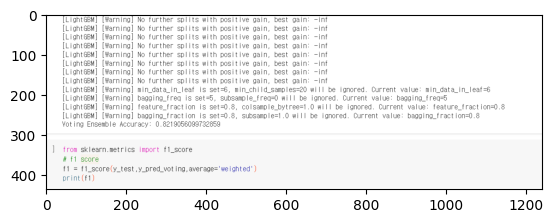

In [32]:
import cv2
image_path = "/content/drive/MyDrive/goingdeeper/day2/acc.png"
img = cv2.imread(image_path)
plt.imshow(img)

### 딥러닝

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split


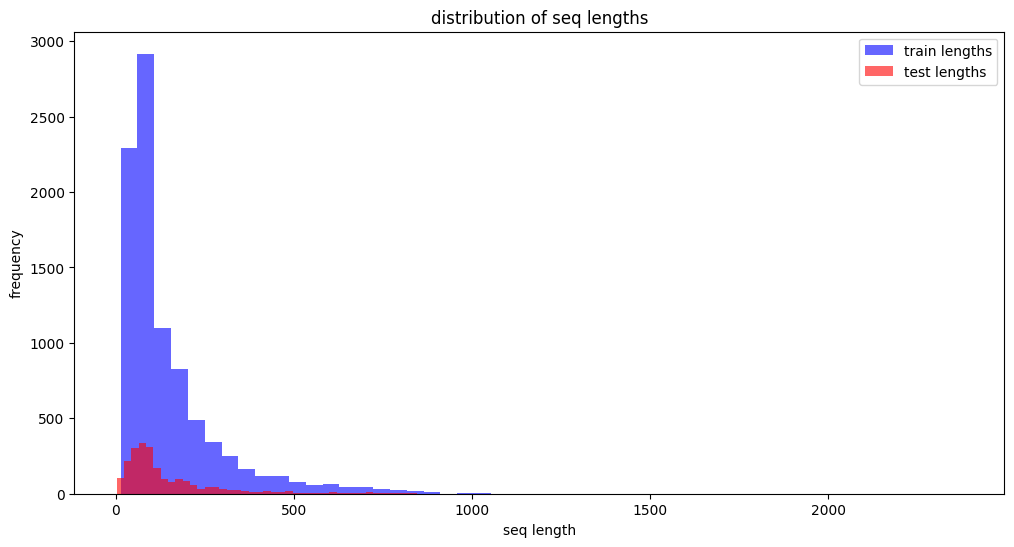

In [19]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

train_lengths = [len(sample) for sample in x_train]
test_lengths = [len(sample) for sample in x_test]

plt.figure(figsize=(12, 6))
plt.hist(train_lengths, bins=50, alpha=0.6, color='blue', label='train lengths')
plt.hist(test_lengths, bins=50, alpha=0.6, color='red', label='test lengths')
plt.title("distribution of seq lengths")
plt.xlabel("seq length")
plt.ylabel("frequency")
plt.legend()
plt.show()

In [20]:
# train에서 train, val 분리
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train,
    test_size=0.2,  # 20%
    random_state=42,
    stratify=y_train  # 클래스 비율 유지. 안그래도 불균형인데 음..
)

word_index = reuters.get_word_index()  # 단어 사전
vocab_size = len(word_index) + 1       # 로이터? 데이터 단어 사전 전부 사용 pad만 필요. unk 필요 없음 분류니까 sos도 필요없을듯?
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 30980


In [21]:
print("y_train 원본 확인:", y_train[:5])

y_train 원본 확인: [3 4 4 3 4]


In [22]:
# 패딩
max_len = 400  # 너무 많은것 같긴 한데

x_train = pad_sequences(x_train, maxlen=max_len, padding='post')
x_val = pad_sequences(x_val, maxlen=max_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_len, padding='post')

# num_classes를 정수 레이블에서 계산
num_classes = int(np.max(y_train) + 1)
print("Number of Classes:", num_classes)

# 원-핫 인코딩
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

print("x_train.shape:", x_train.shape)
print("x_val.shape:", x_val.shape)
print("x_test.shape:", x_test.shape)
print("y_train.shape:", y_train.shape)
print("y_val.shape:", y_val.shape)
print("y_test.shape:", y_test.shape)

Number of Classes: 46
y_train.shape: (7185, 46)
y_val.shape: (1797, 46)
y_test.shape: (2246, 46)
x_train.shape: (7185, 400)
x_val.shape: (1797, 400)
x_test.shape: (2246, 400)
y_train.shape: (7185, 46)
y_val.shape: (1797, 46)
y_test.shape: (2246, 46)


In [23]:
word_index = reuters.get_word_index()  # 단어 사전
vocab_size = len(word_index) + 1       # 단어 사전 크기 (+1은 패딩 토큰만 포함 unk x)
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 30980


In [24]:
# 모델 생성
model = Sequential([
    Embedding(input_dim=30980, output_dim=256, input_length=100),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(46, activation='softmax') # 다중클래스 소프트맥스
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# val_acc가 가장 높은
checkpoint_path = "best_model_val_acc.keras"

# 체크포인트
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# 학습
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[checkpoint]
)

# 로드
model.load_weights(checkpoint_path)
print("val_acc 최고인 가중치0")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3800 - loss: 2.6122
Epoch 1: val_accuracy improved from -inf to 0.58987, saving model to best_model_val_acc.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 24s 112ms/step - accuracy: 0.3809 - loss: 2.6083 - val_accuracy: 0.5899 - val_loss: 1.6591
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5869 - loss: 1.7045
Epoch 2: val_accuracy improved from 0.58987 to 0.62326, saving model to best_model_val_acc.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 14s 106ms/step - accuracy: 0.5870 - loss: 1.7040 - val_accuracy: 0.6233 - val_loss: 1.5608
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6415 - loss: 1.4699
Epoch 3: val_accuracy improved from 0.62326 to 0.63050, saving model to best_model_val_acc.keras
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 105ms/step - accuracy: 0.6416 - loss: 1.4698 - val_accuracy: 0.6305 - val_loss: 1.4883
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6737 - loss: 1.3079
Epoch 4: val_ac

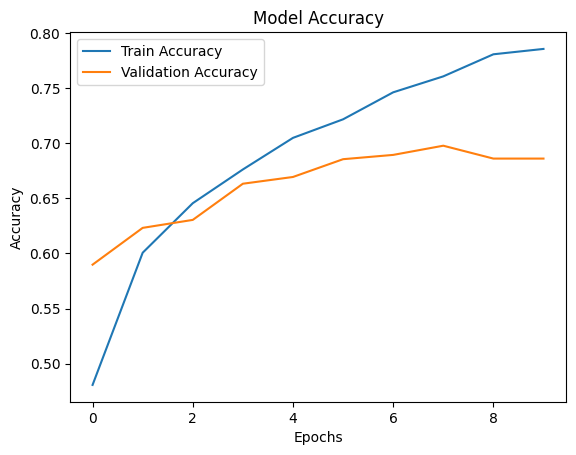

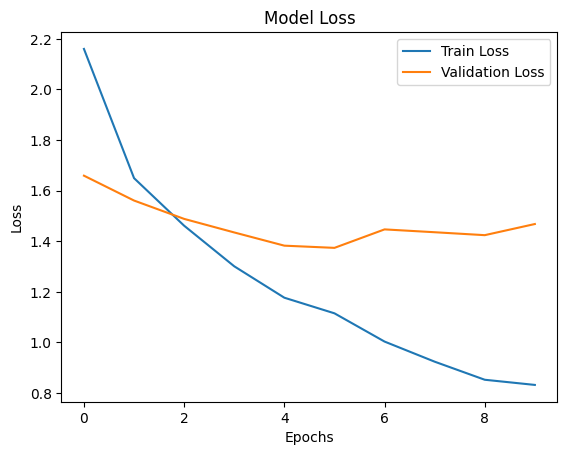

In [25]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# 테스트 평가
y_test_pred_prob = model.predict(x_test)  # 예측 확률
y_test_pred = y_test_pred_prob.argmax(axis=1)  # 가장 높은 확률 클래스 선택
y_test_true = y_test.argmax(axis=1)  # 실제 클래스

# F1-Score
f1 = f1_score(y_test_true, y_test_pred, average='weighted')  # F1-Score
print("Weighted F1-Score:", f1)

print("Classification Report:")
print(classification_report(y_test_true, y_test_pred))

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Weighted F1-Score: 0.6535168029625029
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.55      0.84      0.67       105
           2       0.00      0.00      0.00        20
           3       0.90      0.94      0.92       813
           4       0.81      0.82      0.81       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.36      0.66      0.46        38
           9       0.14      0.04      0.06        25
          10       0.20      0.37      0.26        30
          11       0.51      0.59      0.55        83
          12       0.00      0.00      0.00        13
          13       0.10      0.38      0.16        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
accuracy = accuracy_score(y_test_true, y_test_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.6861086375779163


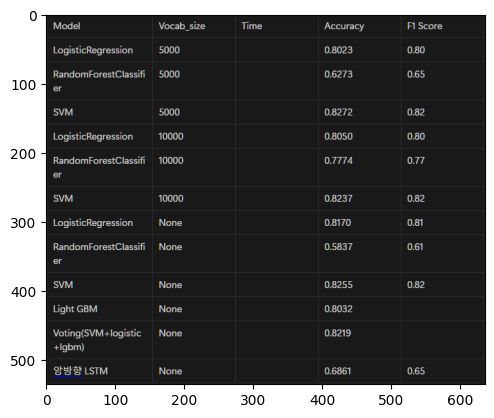

In [35]:
image_path = "/content/drive/MyDrive/goingdeeper/day2/33.png"
img = cv2.imread(image_path)
plt.imshow(img)